In [5]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
from EHydro_TreeUnet.trainers import TreeProjectorTrainer
from torchsparse.nn import functional as F
from torchsparse.utils.quantize import sparse_quantize
from scipy.ndimage import gaussian_filter, maximum_filter

F.set_kmap_mode("hashmap_on_the_fly")

In [6]:
TRAINING = False

DATASET_FOLDER = Path.home() / 'datasets/MixedDataset'
WEIGHTS_FILE = 'tree_projector_weights.pth'
FEAT_KEYS = ['intensity']
IGNORE_CLASS = []
CHANNELS = [16, 32, 64, 128]
LATENT_DIM = 256
MAX_INSTANCES = 64
TRAIN_PCT = 0.8
VOXEL_SIZE = 0.2
DATA_AUGMENTATION_COEF = 8.0
SEMANTIC_LOSS_COEF = 1.0
DIR_LOSS_COEF = 1.0
MAG_LOSS_COEF = 1.0
INSTANCE_LOSS_COEF = 1.0
BATCH_SIZE = 1

In [7]:
def smooth(arr: np.ndarray, window: int) -> np.ndarray:
    if window <= 1:
        return arr

    kernel = np.ones(window, dtype=float)

    if arr.ndim == 1:
        denom = np.convolve(np.ones_like(arr), kernel, mode="same")
        return np.convolve(arr, kernel, mode="same") / denom

    # 2-D: suavizar cada columna por separado
    smoothed = np.empty_like(arr, dtype=float)
    denom = np.convolve(np.ones(arr.shape[0]), kernel, mode="same")
    for c in range(arr.shape[1]):
        smoothed[:, c] = np.convolve(arr[:, c], kernel, mode="same") / denom
    return smoothed
        
def gen_charts(trainer, losses, stats, training: bool, window: int = 10, ignore_class = []):
    keys = stats[0].keys()
    stats = {k: np.array([d[k] for d in stats]) for k in keys}

    losses_s      = smooth(np.asarray(losses), window)
    miou_s        = smooth(stats['miou'], window)
    iou_s         = smooth(np.asarray(stats['iou_per_class']), window)
    prec_macro_s  = smooth(stats['precision_macro'], window)
    prec_s        = smooth(np.asarray(stats['precision_per_class']), window)
    recall_macro_s= smooth(stats['recall_macro'], window)
    recall_s      = smooth(np.asarray(stats['recall_per_class']), window)
    f1_macro_s    = smooth(stats['f1_macro'], window)
    f1_s          = smooth(np.asarray(stats['f1_per_class']), window)

    # --- 1. Loss -------------------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(losses_s, label=f"{'Training' if training else 'Inference'} Loss (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Loss")
    plt.title(f"Loss evolution during {'Training' if training else 'Inference'}")
    plt.legend(); plt.grid(True); plt.show()

    # --- 2. mIoU (macro) -----------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(miou_s, label=f"{'Training' if training else 'Inference'} mIoU (MA{window})")
    plt.xlabel("Step"); plt.ylabel("mIoU")
    plt.title(f"mIoU evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 3. IoU per class ----------------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(iou_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("IoU")
    plt.title(f"IoU evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 4. Precision (macro) -----------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(prec_macro_s, label=f"{'Training' if training else 'Inference'} precision (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Precision")
    plt.title(f"Precision evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 5. Precision per class ---------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(prec_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("Precision")
    plt.title(f"Precision evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 6. Recall (macro) ---------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(recall_macro_s, label=f"{'Training' if training else 'Inference'} recall (MA{window})")
    plt.xlabel("Step"); plt.ylabel("Recall")
    plt.title(f"Recall evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 7. Recall per class -------------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(recall_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("Recall")
    plt.title(f"Recall evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 8. F1 (macro) -------------------------------------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(f1_macro_s, label=f"{'Training' if training else 'Inference'} F1 (MA{window})")
    plt.xlabel("Step"); plt.ylabel("F1")
    plt.title(f"F1 evolution during {'Training' if training else 'Inference'}")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    # --- 9. F1 per class -----------------------------------------------------
    plt.figure(figsize=(10, 5))
    for c in range(trainer.dataset.num_classes):
        if trainer.dataset.class_names[c] in ignore_class:
            continue
        
        plt.plot(f1_s[:, c], label=trainer.dataset.class_names[c])
    plt.xlabel("Step"); plt.ylabel("F1")
    plt.title(f"F1 evolution during {'Training' if training else 'Inference'} (MA{window})")
    plt.ylim(0, 1)
    plt.legend(); plt.grid(True); plt.show()

    column_names = ['IoU', 'Precision', 'Recall', 'F1']
    row_names = [trainer.dataset.class_names[c] for c in range(trainer.dataset.num_classes) if trainer.dataset.class_names[c] not in ignore_class]
    row_names.append('Mean')

    iou_arr = np.asarray(stats['iou_per_class'])
    prec_arr = np.asarray(stats['precision_per_class'])
    recall_arr = np.asarray(stats['recall_per_class'])
    f1_arr = np.asarray(stats['f1_per_class'])

    data = [
        [iou_arr[:, c].mean(), prec_arr[:, c].mean(), recall_arr[:, c].mean(), f1_arr[:, c].mean()]
    for c in range(trainer.dataset.num_classes) if trainer.dataset.class_names[c] not in ignore_class]

    means = np.array(data).mean(axis=0)
    data.append(list(means))

    df = pd.DataFrame(data, columns=column_names, index=row_names)
    display(df)

tf32 enabled: False
Parámetros totales: 12,861,303
Parámetros entrenables: 12,861,303


[Inference]: 100%|██████████| 19/19 [00:19<00:00,  1.03s/it, loss=1.3593, mIoU=0.7519]


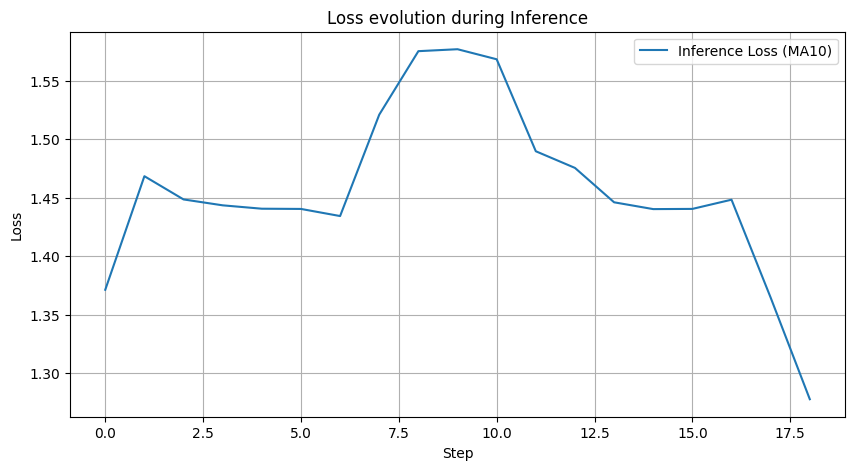

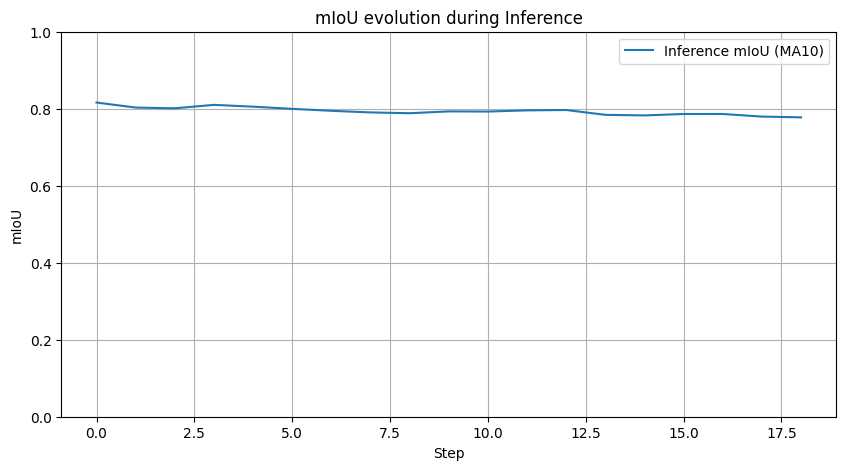

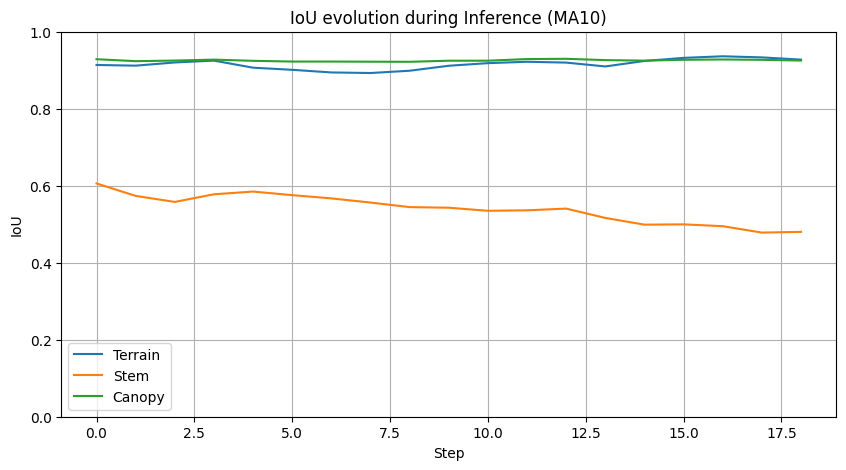

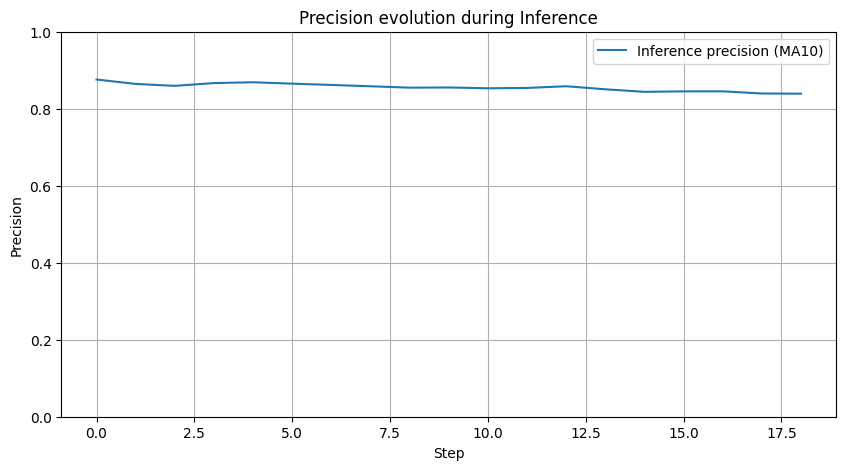

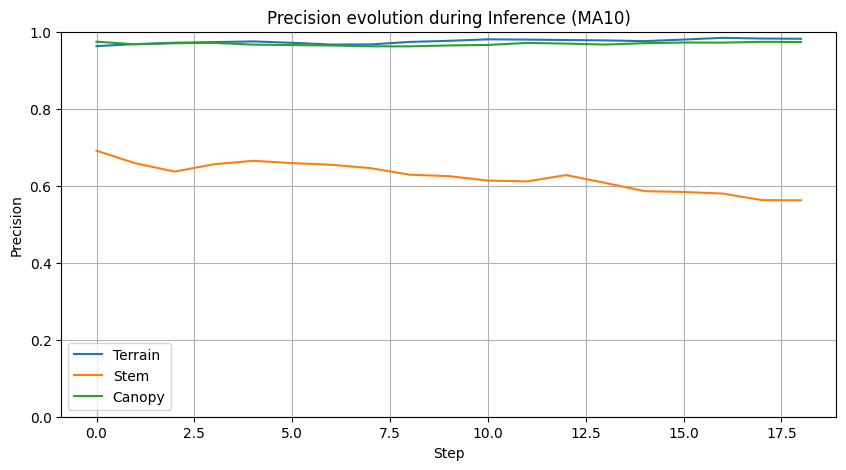

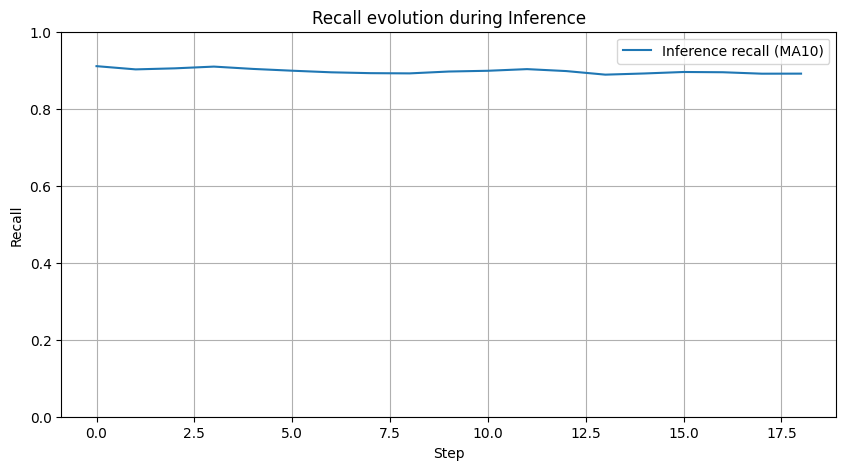

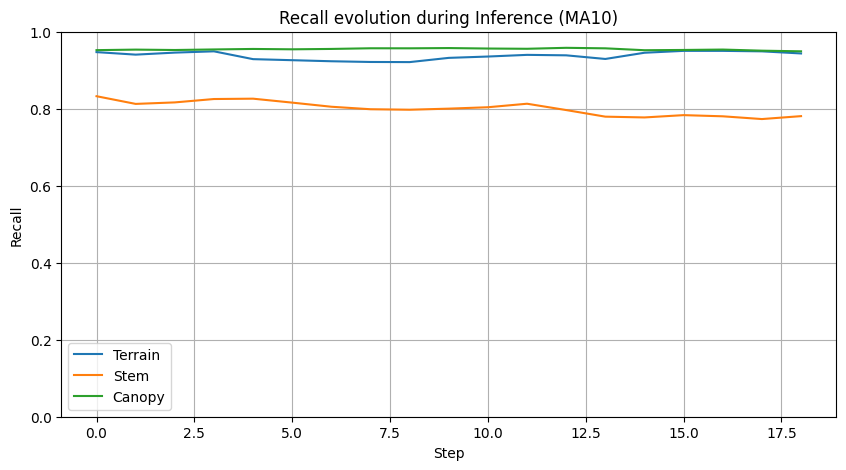

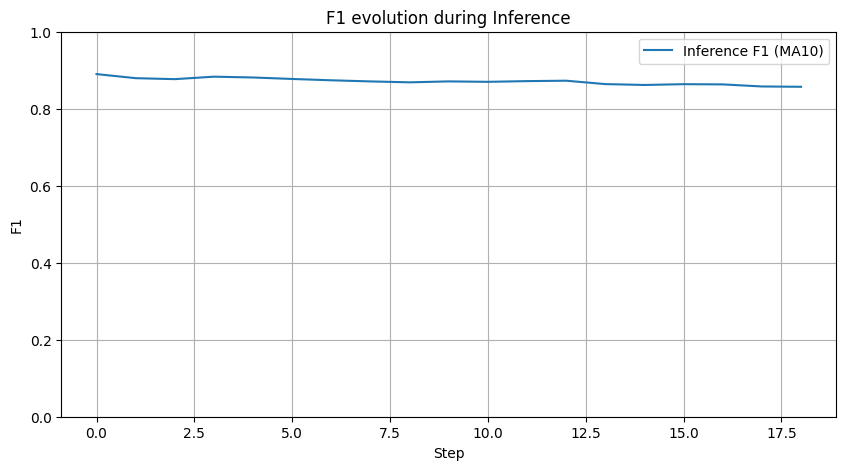

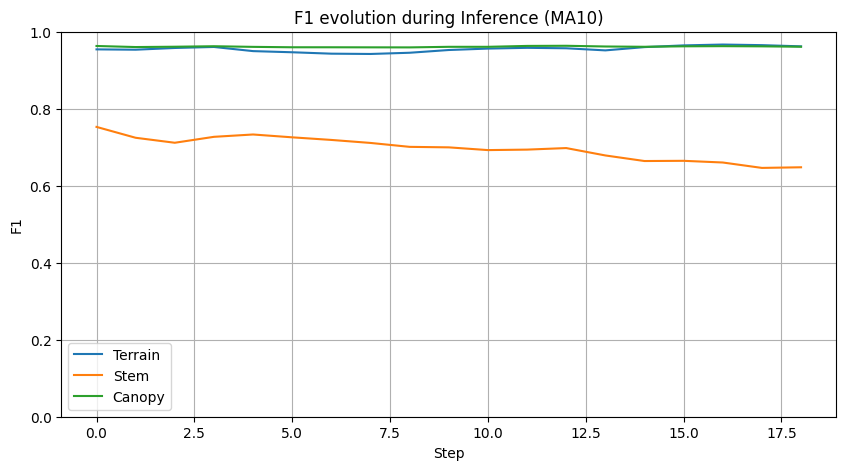

,IoU,Precision,Recall,F1
Terrain,0.915763,0.975210,0.937521,0.955103
Stem,0.539589,0.623251,0.800442,0.696791
Canopy,0.924687,0.968454,0.953516,0.960787
Mean,0.793347,0.855638,0.897160,0.870894


In [8]:
tester = TreeProjectorTrainer(
    dataset_folder=DATASET_FOLDER,
    voxel_size=VOXEL_SIZE,
    train_pct=TRAIN_PCT,
    data_augmentation_coef=DATA_AUGMENTATION_COEF,
    feat_keys=FEAT_KEYS,
    max_instances=MAX_INSTANCES,
    channels=CHANNELS,
    latent_dim=LATENT_DIM,
    batch_size=BATCH_SIZE,
    training=TRAINING,
    semantic_loss_coef=SEMANTIC_LOSS_COEF,
    dir_loss_coef=DIR_LOSS_COEF,
    mag_loss_coef=MAG_LOSS_COEF,
    instance_loss_coef=INSTANCE_LOSS_COEF,
    weights_file=WEIGHTS_FILE
)

if TRAINING:
    tester.train()
    stats = tester.stats
    losses = tester.losses
    gen_charts(tester, losses, stats, True, ignore_class=IGNORE_CLASS)

pcd = o3d.geometry.PointCloud()
pcd2 = o3d.geometry.PointCloud()
for voxels, semantic_output, offset_dir_output, offset_mag_output, semantic_labels, offset_dir_labels, offset_mag_labels in tester.eval():
    continue

    batch_idx = voxels[:, 0]
    voxels = voxels[:, 1:]

    for idx in np.unique(batch_idx):
        mask = batch_idx == idx
        cloud_voxels = voxels[mask]
        cloud_semantic_output = semantic_output[mask]
        cloud_semantic_labels = semantic_labels[mask]

        cloud_dir_offset_output = offset_dir_output[mask]
        cloud_mag_offset_output = offset_mag_output[mask]

        cloud_dir_offset_labels = offset_dir_labels[mask]
        cloud_mag_offset_labels = offset_mag_labels[mask]

        pcd.points = o3d.utility.Vector3dVector(cloud_voxels)

        colors = tester.dataset.class_colormap[cloud_semantic_labels] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        colors = tester.dataset.class_colormap[cloud_semantic_output] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        pcd.colors = o3d.utility.Vector3dVector(colors * 0.5)
        centers = cloud_voxels + (cloud_dir_offset_labels * np.expm1(cloud_mag_offset_labels))
        centers = centers[cloud_semantic_labels != 0]
        centers = np.unique(np.floor(centers).astype(int), axis=0)

        spheres = []
        for center in centers:
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.6)
            sphere.translate(center)
            sphere.paint_uniform_color([1, 0, 0])  # rojo
            spheres.append(sphere)

        # pcd2.points = o3d.utility.Vector3dVector(centers)
        # pcd2.paint_uniform_color([1, 0, 0])
        o3d.visualization.draw_geometries([pcd] + spheres)

        centers = cloud_voxels + (cloud_dir_offset_output * np.expm1(cloud_mag_offset_output))
        centers = centers[cloud_semantic_output != 0]
        centers = np.unique(np.floor(centers).astype(int), axis=0)

        pcd2.points = o3d.utility.Vector3dVector(centers)
        pcd2.paint_uniform_color([1, 0, 0])
        o3d.visualization.draw_geometries([pcd, pcd2])

        votes = cloud_voxels + (cloud_dir_offset_output * np.expm1(cloud_mag_offset_output))
        min_corner = np.floor(votes.min(axis=0)).astype(int)
        grid_coords = votes - min_corner               # ahora ≥0
        grid_idx = np.rint(grid_coords).astype(int)    # vóxel más cercano

        # tamaño del acumulador
        shape = grid_idx.max(axis=0) + 1
        accum = np.zeros(shape, dtype=np.float32)

        for v in grid_idx:
            accum[tuple(v)] += 1.0

        sigma = 1.0
        thr_frac = 0.1

        accum = gaussian_filter(accum, sigma=sigma, mode="constant")
        # máximo local 3×3×3
        neigh = maximum_filter(accum, size=3, mode="constant")
        peaks = (accum == neigh) & (accum > thr_frac * accum.max())

        centers = np.argwhere(peaks) + min_corner  # (K,3) en voxeles originales

        spheres = []
        for center in centers:
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.6)
            sphere.translate(center)
            sphere.paint_uniform_color([1, 0, 0])  # rojo
            spheres.append(sphere)

        o3d.visualization.draw_geometries([pcd] + spheres)

        '''
        center_voxels = tree_voxels + tree_offsets

        colors = tester.dataset.class_colormap[tree_semantic] / 255.0
        pcd.colors = o3d.utility.Vector3dVector(colors)

        pcd.points = o3d.utility.Vector3dVector(center_voxels)
        o3d.visualization.draw_geometries([pcd])

        pcd.points = o3d.utility.Vector3dVector(cloud_voxels)

        unique_ids = np.unique(cloud_instance_labels)
        rng = np.random.default_rng(0)
        palette = rng.random((len(unique_ids), 3))

        id2color = {uid: palette[i] for i, uid in enumerate(unique_ids)}
        colors = np.array([id2color[i] for i in cloud_instance_labels], dtype=np.float64)

        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])

        unique_ids = np.unique(cloud_instance_output)
        rng = np.random.default_rng(0)
        palette = rng.random((len(unique_ids), 3))

        id2color = {uid: palette[i] for i, uid in enumerate(unique_ids)}
        colors = np.array([id2color[i] for i in cloud_instance_output], dtype=np.float64)

        pcd.colors = o3d.utility.Vector3dVector(colors)
        o3d.visualization.draw_geometries([pcd])
        '''

gen_charts(tester, tester.losses, tester.stats, False, ignore_class=IGNORE_CLASS)
